<center><h1>Hands-On Reinforcement Learning Applied to Trade Execution Algorithms</h1></center>
<center>
Autor: <cite><a href="https://www.linkedin.com/in/aoteog/">Oteo García, Alberto</a></cite>
</center>
<center>
Autor: <cite><a href="https://www.linkedin.com/in/jesus-sanz/">Sanz del Real, Jesús</a></cite>
</center>

----------------



In [1]:
from collections import deque
import pickle
import sys
from typing import Any, List, Sequence, Tuple
from collections import  deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../src/")
from agents.dqn import DDQNAgent
from report.report import plot_results

2023-09-14 19:27:13.442923: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-14 19:27:13.442976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
with open("../../data/rep_data.pickle", "rb") as f:
        dict_ = pickle.load(f)
data = dict_["train"]

In [3]:
data.keys()

dict_keys([datetime.date(2018, 1, 2), datetime.date(2018, 1, 3), datetime.date(2018, 1, 4), datetime.date(2018, 1, 5), datetime.date(2018, 1, 8), datetime.date(2018, 1, 9), datetime.date(2018, 1, 10), datetime.date(2018, 1, 11), datetime.date(2018, 1, 12), datetime.date(2018, 1, 15), datetime.date(2018, 1, 16), datetime.date(2018, 1, 17), datetime.date(2018, 1, 18), datetime.date(2018, 1, 19), datetime.date(2018, 1, 22), datetime.date(2018, 1, 23), datetime.date(2018, 1, 24), datetime.date(2018, 1, 25), datetime.date(2018, 1, 26), datetime.date(2018, 1, 29), datetime.date(2018, 1, 30), datetime.date(2018, 1, 31), datetime.date(2018, 2, 1), datetime.date(2018, 2, 2), datetime.date(2018, 2, 5), datetime.date(2018, 2, 6), datetime.date(2018, 2, 7), datetime.date(2018, 2, 8), datetime.date(2018, 2, 9), datetime.date(2018, 2, 12), datetime.date(2018, 2, 13), datetime.date(2018, 2, 14), datetime.date(2018, 2, 15), datetime.date(2018, 2, 16), datetime.date(2018, 2, 19), datetime.date(2018, 2,

---
# Entorno

In [7]:
class BestExecutionEnv:
    """
    
    """
    def __init__(self, data, look_back=60):
        """Inicialización de la clase del entorno que simula
        el libro de ordenes.
        ----------------------------------------------------
        Input:
            - data: 
                Dataframe con los datos previamente
                agrupados del libro de órdenes.
            
            - look_back: 
                Ventana para la generación de features
                roladas en el instante t=0 del episodio.
                Esta ventana representa el rango máximo para
                la construcción de features.
        ----------------------------------------------------
        Variables Internas:
            - episode_bins:
                Número de bines (steps) del episodio.
            - episode_full_len:
                Es igual a look_back + episode_bins.
            - vol_care:
                Volumen total (en títulos) de la orden care.
            - actions_fn:
                Diccionario con las posibles acciones del agente.
                Las claves acceden a la función que evalúa  la acción
                tomada por el agente.
            - n_actions:
                Número de acciones posibles.
            - n_features:
                Número de características de los estados.
            - episode:
                Dataframe que contiene los steps y estados del episodio.
            - episode_full:
                Es el episode añadiendo el look_back antes del comienzo 
                del episodio.
            - episode_vwap:
                VWAP de mercado al final del episodio.
            - market_ep_vol:
                Volumen (títulos) ejecutado por el mercado en cada bin del episodio.
            - state_pos:
                Número de step en el que nos encontramos.
            - exec_vol:
                Acumulado de títulos ejecutados por el algoritmo.
            - action_hist:
                Lista de acciones tomadas por el algoritmo en cada step.
            - market_vwap_hist:
                Lista de VWAP de mercado en cada step.
            - reward_hist:
                Lista de rewards obtenidas en cada step.
            - price_hist:
                Lista de precios ejecutados en cada step.
            - vol_hist:
                Lista de títulos ejecutados en cada step.                
        """
        
        # Fixed params
        self.data = data
        self.look_back = look_back
        self.episode_bins = None
        self.episode_full_len = None
        self.vol_care = None
        
        self.actions_fn = {
            0: self._do_nothing,
            1: self._agg_action,
        }
        
        self.n_actions = len(self.actions_fn)
        self.n_features = self._detect_num_feat()

        # Data variables
        self.episode = None
        self.episode_full = None
        
        # Env variables
        self.episode_vwap = None
        self.market_ep_vol = None
        self.state_pos = 0
        self.exec_vol = 0
        self.actions_hist = []
        self.algo_vwap_hist = []
        self.market_vwap_hist = []
        self.reward_hist = []
        self.price_hist = []
        self.vol_hist = []
        
    def _detect_num_feat(self):
        """Detecta el número de variables del estado.
        Función necesaria para adaptarse automaticamente a los
        cambios en las variables de observation_builder.
        """
        self._reset_env_episode_params()
        self._generate_episode()
        s = self.observation_builder()
        return s.shape[0]
        
    def _reset_env_episode_params(self):
        """
        Reset del episodio e inicialización de los parámetros.
        Las variables internas vuelven a sus valores originales.
        """
        self.episode_full_len = None
        self.episode = None
        self.episode_full = None
        self.episode_vwap = None
        self.market_ep_vol = None
        self.state_pos = 0
        self.algo_vwap = 0
        self.exec_vol = 0
        self.actions_hist = []
        self.algo_vwap_hist = []
        self.market_vwap_hist = []
        self.reward_hist = []
        self.price_hist = []
        self.vol_hist = []
        
    def _generate_episode_params(self):
        """Se determinan las características de la orden a ejecutar.
        La órden queda definida por: 
         - episode_bins:
             Obtención de un número entero aleatorio [400, 600] 
             con una distribución uniforme.
         - vol_care:
             Obtención del porcentaje de steps en el que hay que 
             ejecutar una órden para cubrir la órden care. 
             vol_care responde a un valor uniforme [0.075, 0.125]
             multiplicado por el número self.episode_bins. 
             Lo convertimos a entero.
        """
        # TODO: Int aleatorio entre 400 y 600 como un objeto numpy
        self.episode_bins = np.random.randint(low=400, high=600)
        # TODO: Float aleatorio entre 0.075 y 0.125
        pct_bins = np.random.uniform(low=0.075, high=0.125)
        # TODO: Int multiplicacion pct_bins y episode_bins
        self.vol_care = int(pct_bins * self.episode_bins)
        
        self.episode_full_len = self.episode_bins + self.look_back
        
        assert self.episode_bins <= 600
        assert self.episode_bins >= 400
        assert self.vol_care <= int(self.episode_bins * 0.125)
        assert self.vol_care >= int(self.episode_bins * 0.075)
        assert isinstance(self.vol_care, int)
        
    def _generate_episode(self):
        """Obtenemos el día y hora en el que comienza el episodio.
        """
        self._generate_episode_params()
        
        lenght_episode = 0
        while lenght_episode != self.episode_full_len:
            # TODO: Selección de un dia entre los posibles.
            # Clue: Usa np.random.choice y los dias data.keys
            selected_day = np.random.choice(
                    list(self.data.keys()
                )
            )
            
            # TODO: Extrae selected_day de data
            data_day = self.data[selected_day]
            
            # TODO: selecciona una hora de inicio aleatoria
            init_time = np.random.choice(data_day.index)
            
            hour_pos = data_day.index.get_loc(init_time)
            initial_position = hour_pos - self.look_back
            final_position = hour_pos + self.episode_bins
            
            if initial_position < 0:
                continue
            else:
                # TODO: Filtra data_day entre por initial_position y final_position
                self.episode_full = data_day.iloc[initial_position:final_position, :]
                
                # TODO: Filtra data_day entre por hour_pos y final_position
                self.episode = data_day.iloc[hour_pos:final_position, :]
                
                lenght_episode = self.episode_full.shape[0]
        
            
    def reset(self) -> np.array:
        """Reinicialización del episodio junto con los parámetros.
        Devuelve la primera observación del nuevo episodio.
        """  
        self._reset_env_episode_params()     
        self._generate_episode()
        self._compute_episode_market_feat()
        
        return self.observation_builder()
    
    def observation_builder(self) -> np.array:
        """ Función para la construcción de las observaciones del estado.
            ------------------------------------------------------------
            Default:
                - Primera característica es tiempo restante en porcentaje.
                - Seguna característica es el volumen restante en porcentaje.
        """
        # TODO: Construye el vector con las dos características de la descripción
        # Clue: Utiliza episode_bins, state_pos, exec_vol ,vol_care
        time_left = (self.episode_bins - self.state_pos) / self.episode_bins
        vol_left = 1 - (self.exec_vol / self.vol_care)
        obs  = np.array([time_left, vol_left])
        
        return obs
    
    def _compute_episode_market_feat(self) -> Tuple[float, float]:
        """Cálculo de los valores VWAP y Market Vol del episodio.
        Como no tenemos las ejecuciones de mercado, asumimos que el 
        precio es el mid price de cada step.
        """
        # TODO: Calcula el mid price utilizando ask1 y bid1 de episode
        # Opcional: Utiliza un precio más realista para el mkt VWAP
        mid = (self.episode["ask1"] + self.episode["bid1"]) / 2
        # TODO: Calcula market_ep_vol
        self.market_ep_vol = self.episode.cumvol.diff()
        self.market_ep_vol[0] = 0
        # TODO: calcula el volumen acumulado del mercado en todo el episodio
        cum_vol = self.market_ep_vol.sum()
        # TODO: calcula el episode_vwap
        self.episode_vwap = (mid[:-1] * self.market_ep_vol[1:]).sum() / cum_vol
        
        return self.episode_vwap, self.market_ep_vol
    
    def _compute_algo_vwap(self) -> float:
        """Cálculo del VWAP del algoritmo hasta el step actual.
        """
        # TODO: Calcula el algo_vwap
        # Clue: utiliza price_hist, vol_hist
        p_arr = np.array(self.price_hist)
        v_arr = np.array(self.vol_hist)
        algo_vwap = np.sum(p_arr * v_arr) / np.sum(v_arr)
        return algo_vwap
    
    def _compute_reward(self, price: float, vol: float) -> float:
        """Función de diseño de los rewards y penalizaciónes que 
        recibe el algoritmo al tomar las acciones.
        --------------------------------------------------------
        Default:
            - El reward es el ratio de la diferencia entre el episode_vwap y
              el precio de la acción tomada, dividido entre episode_vwap.
        """
    
        # TODO: Establece y devuelve un reward cuando vol == 0
        if vol == 0:
            reward = 0
            return reward
        # TODO: Calcula y devuelve el reward cuando vol > 0
        # Clue: Utiliza episode_vwap y price para la reward por defecto
        # Opcional: Utiliza el self y elimina los parámetros de la función
        reward = (self.episode_vwap - price) / self.episode_vwap
        return reward
    
    def _compute_stop_conditions(self) -> Tuple[bool, bool]:
        """Define las condiciones de parada del episodio
        Return:
            Tiempo agotado, orden completada
        """
        # TODO: Calcula las variables de parada y devuélvelas en el orden apropiado
        is_bins_complete = self.state_pos == self.episode_bins
        is_ord_complete = self.exec_vol == self.vol_care
        return is_bins_complete, is_ord_complete
    
    def _compute_done_reward(self) -> float:
        # TODO: Free style
        _, is_ord_complete = self._compute_stop_conditions()
        rwd_factor = not is_ord_complete
        done_reward = -1 * rwd_factor
        return done_reward
    
    def _agg_action(self) -> float:
        """Acción agresiva de compra de un título a precio de episode['ask1'].
        Devolvemos el reward asociado a esa acción.
        """
        # TODO: obtén el precio de la accion agresiva (ask1) en el state_pos
        price = self.episode["ask1"].values[self.state_pos]
        # TODO: guarda price en price_hist, añade 1 a exec_vol y añade 1 a vol_hist
        self.price_hist.append(price)
        exec_vol = 1
        self.exec_vol += exec_vol
        self.vol_hist.append(exec_vol)
        
        # TODO: utiliza la función apropiada para calcula el algo_vwap
        algo_vwap = self._compute_algo_vwap()
        # guarda el algo_vwap en algo_vwap_hist
        self.algo_vwap_hist.append(algo_vwap)
        # TODO: calcula el reward utilizando la función apropiada
        reward = self._compute_reward(price, exec_vol)
        return reward

    def _do_nothing(self) -> float:
        """No hacer nada y devolvemos el reward asociado a la acción
        """
        # TODO: Repite el proceso de _agg_action
        # Clue: Precio y volumen ejecutado = 0
        price = 0
        exec_vol = 0
        self.price_hist.append(price)
        self.vol_hist.append(exec_vol)
        algo_vwap = self.algo_vwap_hist[-1]
        self.algo_vwap_hist.append(algo_vwap)
        reward = self._compute_reward(price, exec_vol)
        
        return reward
    
    def _compute_market_vwap(self) -> float:
        """Cálculo del VWAP del mercado hasta el step actual.
        """
        # TODO: Establece un para el vol ejecutado por el mkt en cada step
        # Clue: puedes fijarte en _compute_episode_market_feat
        mid_p = (self.episode["ask1"] + self.episode["bid1"]) / 2
        mkt_p = (mid_p + mid_p.shift(-1).ffill()) / 2
        # Calcula todos los vwap del mkt hasta el step actual incluido
        v = self.episode["cumvol"].diff().shift(-1)
        p_arr = mkt_p.values[:self.state_pos + 1]
        v_arr = v.values[:self.state_pos + 1]
        sum_vol = np.sum(v_arr)
        # Si el mkt vol hasta el step == 0, devuelve el último precio hasta el step
        if sum_vol == 0:
            return p_arr[-1]
        # Calcula y devuelve el vwap acumulado hasta el step
        market_vwap = np.sum(p_arr * v_arr) / sum_vol
        return market_vwap
    
    def _compute_done(self) -> bool:
        """ Reglas de finalización del episodio.
        """
        # TODO: Calcula las condiciones de parada utilizando la función adecuada
        conditions = self._compute_stop_conditions()
        is_bins_complete = conditions[0]
        is_ord_complete = conditions[1]
        # TODO: Devuelve done == True si se cumplen cualquiera de las condiciones
        done = is_bins_complete or is_ord_complete
        return done

    def step(self, action) -> Tuple[np.array, float, bool, dict]:
        """ Evalua la acción, calcula la recompensa, devuelve el 
        nuevo estado y si el episodio ha terminado.
        """
        
        market_vwap = self._compute_market_vwap()
        act_fn = self.actions_fn.get(action)
        if act_fn is None:
            raise ValueError(
                f"Invalid action {action}. Valid actions {self.actions_fn.keys()}"
            )
        
        reward = act_fn()

        self.market_vwap_hist.append(market_vwap)
        self.reward_hist.append(reward)
        
        self.state_pos += 1
        
        done = self._compute_done()
        
        if done:
            reward += self._compute_done_reward()
            return None, reward, done, {}
        
        observation = self.observation_builder()
        
        return np.array(observation), reward, done, {}
    
    def action_sample(self) -> int:
        """
        Devuelve una acción aleatoria. El valor ha de corresponder 
        con las keys de actions_fn.
        """
        # TODO: Toma una acción aleatoria
        # Opcional: ¿Qué distribución de prob es mejor para la exploración?
        p = self.vol_care / self.episode.shape[0]
        action = np.random.choice([0, 1], p=[1-p, p])
        return action

    def stats_df(self):
        """Información para el gráfico de resultados de la ejecución
        """
        
        my_df = pd.DataFrame(
            {"vwap": self.algo_vwap_hist, "vol": self.vol_hist},
            index=list(self.episode.index)[:len(self.algo_vwap_hist)]
        )
        my_df = my_df.reindex(self.episode.index)
        my_df["vol"] = my_df["vol"].fillna(0)
        my_df["vwap"] = my_df["vwap"].ffill()
            
        
        p = self.episode["ask1"]
        v = self.episode["cumvol"].diff().shift(-1)
        last_v = self.episode_full["cumvol"].diff()[-1]
        v.iloc[-1] = last_v
        market_vwap = (p * v).cumsum() / v.cumsum()
        market_df = pd.DataFrame(
            {"vwap": market_vwap, "vol": v},
            index=v.index
        )
        
        mpx = (self.episode["ask1"] + self.episode["bid1"]) / 2
        
        return my_df, market_df, mpx
        
        

In [8]:
class TWAP(DDQNAgent):
    def act(self, s): # [T, V]
        # TODO: Configura un TWAP determinista utilizando s
        if s[1] >= s[0]:
            return 1
        return 0

In [ ]:
40000 / 400

In [18]:
"""
    Agent Params
"""
# TODO: Selecciona un epsilon inicial para el entrenamiento
epsilon = 1
# TODO: Selecciona un min_epsilon para el entrenamiento
min_epsilon = 0.05
# TODO: Selecciona un gamma para el aprendizaje
gamma = 1
# TODO: Selecciona un alpha para el aprendizaje
alpha = 0.0001
# TODO: Selecciona un buffer_size para el aprendizaje
buffer_size = 40000
# TODO: Selecciona un batch_size para el aprendizaje
batch_size = 256
# TODO: Selecciona el número de nueronas para el modelo
hidden_neurons = 240

"""
    Training Params
"""
# TODO: Selecciona el número de episodios
nepisodes = 200
n_log = 25
#TODO: Determina el epsilon_decay para el proceso de entrenamiento
epsilon_decay = (epsilon - min_epsilon) / (nepisodes * 0.95)
learn_after = batch_size

env = BestExecutionEnv(data, 60)

#### Inicialización del agente

In [19]:
agent = DDQNAgent(
    env, gamma=gamma, epsilon=epsilon, alpha=alpha,
    batch_size=batch_size, buffer_size=buffer_size,
    hidden_neurons=hidden_neurons, trainable=True
)

#### Recolección de los Episodios para el Buffer

In [20]:
# En este punto eps es 1 -> actuando random
s = env.reset()
for exps in range(buffer_size):  
    a = agent.act(s)
    s1, r, done, _ = env.step(a)
    agent.experience(s, a, r, s1, done)
    s = s1

    if not exps % 10000:
        print(f'buffer exps: {exps}')
    if done:
        s = env.reset()

buffer exps: 0
buffer exps: 10000
buffer exps: 20000
buffer exps: 30000


#### Train Algo

In [21]:
agent.set_trainable(True)
learn_counter = 0
history_steps = []
history_rewards = []
history_disc_rewards = []
history_losses = []

list_df = []
list_market_df = []
list_mpx = []

for episode in range(nepisodes):
    s = env.reset()
    step = 0
    cum_reward = 0
    dis_cum_reward = 0
    episode_losses = []
    while True:
        a = agent.act(s)
        s1, r, done, _ = env.step(a)
        agent.experience(s, a, r, s1, done)
        learn_counter += 1
        cum_reward += r
        dis_cum_reward += agent.gamma ** step * r
        s = s1
        step += 1
        if not learn_counter % learn_after:
            mse = agent.learn()
        if done:
            agent.epsilon = max([agent.epsilon - epsilon_decay, min_epsilon])
            history_rewards.append(cum_reward)
            history_disc_rewards.append(dis_cum_reward)
            history_losses.append(mse)
            history_steps.append(step)
            
            res = env.stats_df()
            list_df.append(res[0])
            list_market_df.append(res[1])
            list_mpx.append(res[2])
            
            if not episode % n_log:
                mse = agent.learn()
                print(
                    f'Episode: {episode}, '
                    f'steps: {np.round(np.mean(history_steps[-n_log:]), 2)}, '
                    f'rew: {np.round(np.mean(history_rewards[-n_log:]), 2)}, '
                    f'mse: {np.round(mse)}, '
                    f'eps: {np.round(agent.epsilon, 2)}'
                )
            break

Episode: 0, steps: 520.0, rew: -0.03, mse: 0.0, eps: 1.0
Episode: 25, steps: 465.92, rew: -0.62, mse: 0.0, eps: 0.87
Episode: 50, steps: 366.68, rew: -0.15, mse: 0.0, eps: 0.74
Episode: 75, steps: 343.96, rew: -0.07, mse: 0.0, eps: 0.62
Episode: 100, steps: 420.88, rew: -0.05, mse: 0.0, eps: 0.49
Episode: 125, steps: 461.84, rew: -0.07, mse: 0.0, eps: 0.37
Episode: 150, steps: 459.56, rew: -0.08, mse: 0.0, eps: 0.24
Episode: 175, steps: 443.04, rew: -0.09, mse: 0.0, eps: 0.12


#### Plot Results

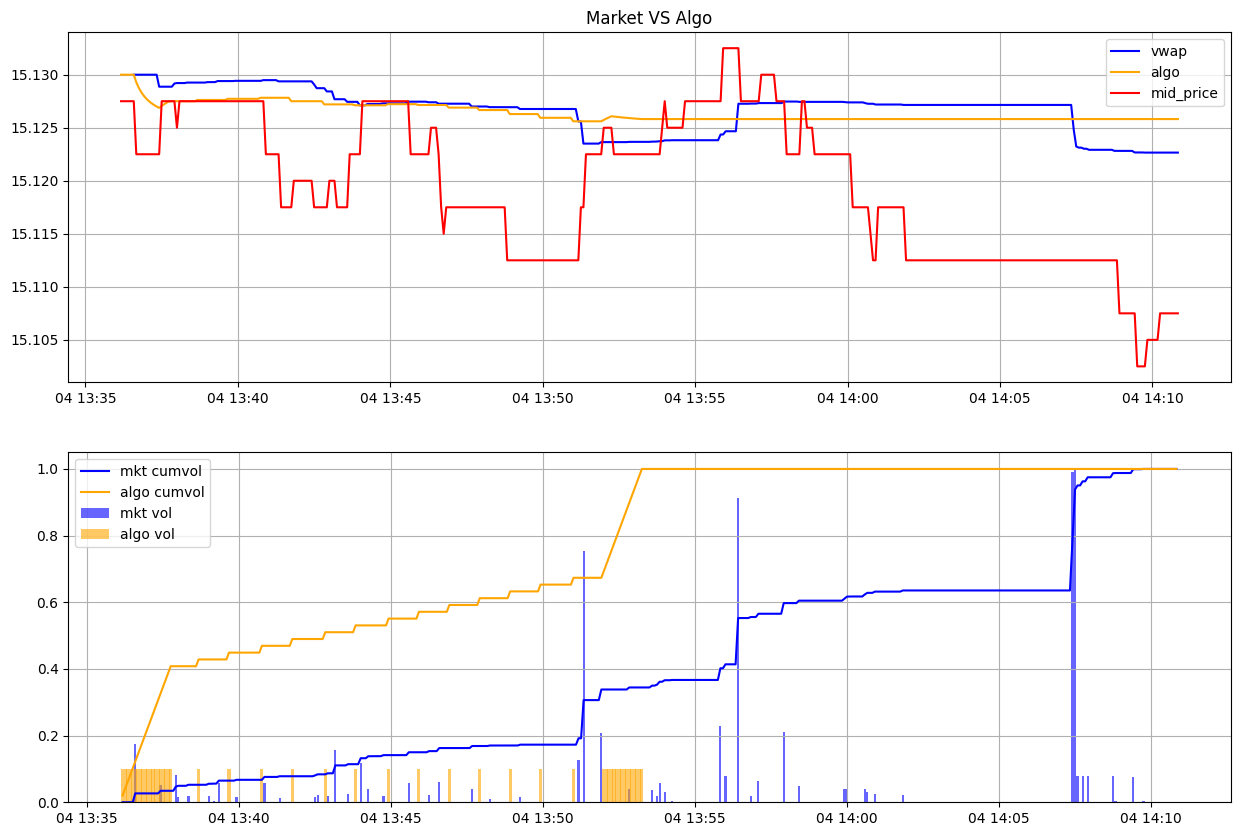

In [22]:
agent.set_trainable(False)
cum_reward = 0
step = 0
env = BestExecutionEnv(dict_["test"], 60)
s = env.reset()
a = 1
s, r, done, _ = env.step(a)
step += 1
cum_reward += agent.gamma ** step * r
while True:
    a = agent.act(s)
    s, r, done, _ = env.step(a)
    step += 1
    cum_reward += agent.gamma ** step * r
    if done:
        break
plot_results(env)